In [1]:
import pandas as pd
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
import matplotlib.pyplot as plt

In [2]:
seals = pd.read_csv('data/harbor_seals.csv')

In [3]:
seals.head()

,year,harbor seals in Wadden Sea (thousands)
0,1997,3.493
1,1998,5.282
2,1999,6.357
3,2000,9.201
4,2001,11.224


In [4]:
seals.tail()

,year,harbor seals in Wadden Sea (thousands)
11,2008,23.869
12,2009,24.243
13,2010,24.344
14,2011,24.919
15,2012,25.108


In [5]:
import random
import numpy as np

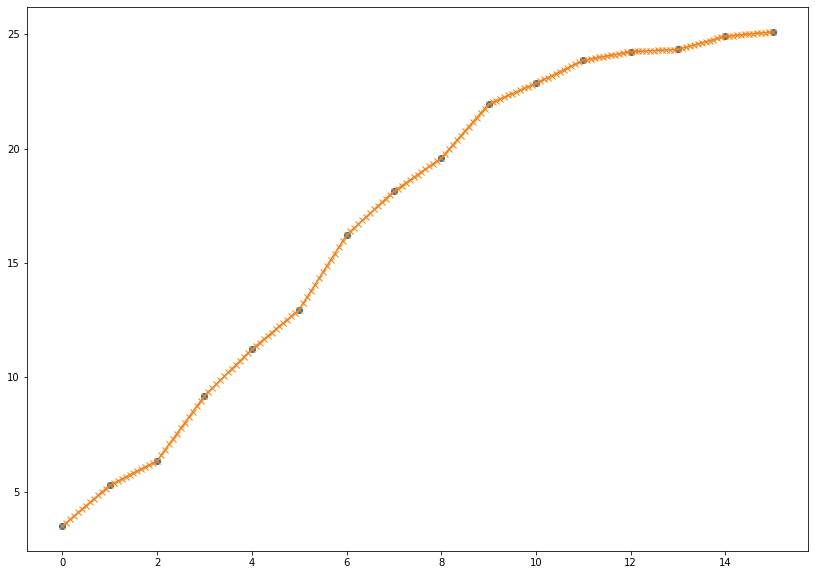

In [6]:
x = range(len(seals['year'].tolist()))
y = seals['harbor seals in Wadden Sea (thousands)'].tolist()

xvals = np.append(np.arange(0, len(x) - 1, 1/12), 15)
yinterp = np.interp(xvals, x, y)

plt.figure(figsize=(14, 10))
plt.plot(x, y, 'o')
plt.plot(xvals, yinterp, '-x')
plt.show()

In [7]:
for i in range(13):
    print(10 * np.sin(i * (360 / 12) * (np.pi / 180)))

0.0
4.999999999999999
8.660254037844386
10.0
8.660254037844387
4.999999999999999
1.2246467991473533e-15
-5.000000000000001
-8.660254037844386
-10.0
-8.660254037844386
-5.000000000000004
-2.4492935982947065e-15


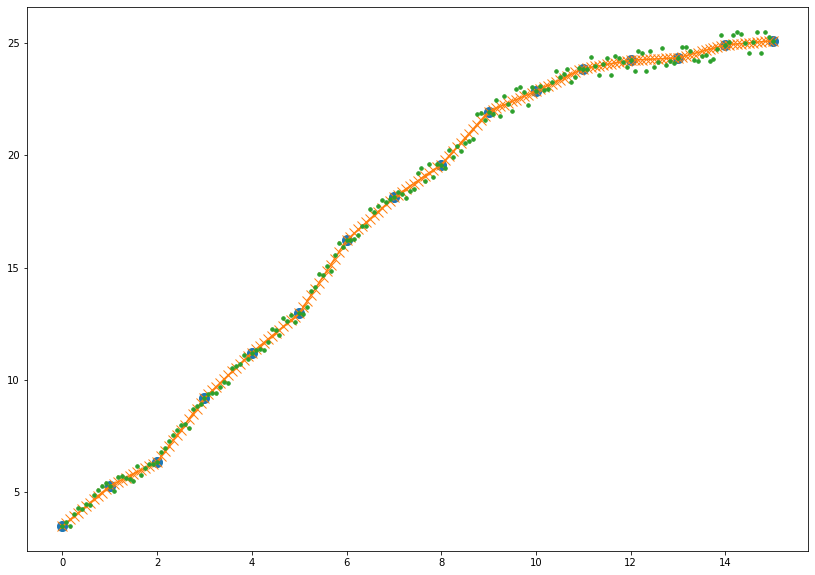

In [8]:
plt.figure(figsize=(14, 10))
plt.plot(x, y, 'o', ms=10)
plt.plot(xvals, yinterp, '-x', ms=10)
plt.plot(xvals, [(yinterp[i] + yinterp[i // 12] / 10 * (random.random() * 2 - 1)) 
                 if i % 12 != 0 
                 else yinterp[i] for i in range(len(yinterp))], '.', ms=7)
plt.show()

In [9]:
df = pd.DataFrame({'ds': pd.to_datetime(pd.date_range('1997-01','2012-02', freq='M').strftime("%Y-%b").tolist()),
                   'y': [int(1000 * (yinterp[i] + sum(yinterp) / len(yinterp) / 100 * (1 + (random.random() * 2 - 1))))
                         if i % 12 != 0
                         else int(1000 * yinterp[i]) for i in range(len(yinterp))]})

In [10]:
# df.rename(columns={'ds': 'date', 'y': 'num_seals'}).to_csv('data/seals.csv', index=False)
df = pd.read_csv('data/seals.csv')
df = df.rename(columns={'date': 'ds', 'num_seals': 'y'})

In [11]:
df.head()

,ds,y
0,1997-01-01,3493
1,1997-02-01,3955
2,1997-03-01,3878
3,1997-04-01,4087
4,1997-05-01,4296


In [12]:
df.tail()

,ds,y
176,2011-09-01,25112
177,2011-10-01,25268
178,2011-11-01,25305
179,2011-12-01,25202
180,2012-01-01,25108


In [13]:
cap = 26000
floor = 0
df['cap'] = cap
df['floor'] = floor

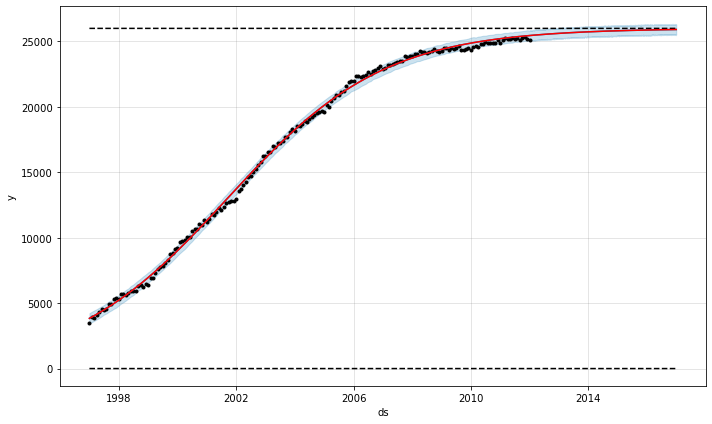

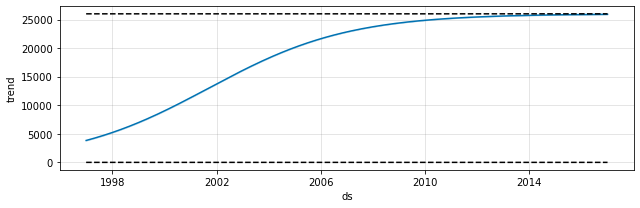

In [14]:
prophet = Prophet(growth='logistic',
                  n_changepoints=25,
                  changepoint_range=0.8,
                  yearly_seasonality=False,
                  weekly_seasonality=False,
                  daily_seasonality=False,
                  holidays=None,
                  seasonality_mode='additive',
                  seasonality_prior_scale=10,
                  changepoint_prior_scale=.01,
                  mcmc_samples=0)
prophet.fit(df)
future = prophet.make_future_dataframe(periods=365 * 5, freq='D')
future['cap'] = cap
future['floor'] = floor
forecast = prophet.predict(future)
fig = prophet.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet, forecast)
plt.show()
fig2 = prophet.plot_components(forecast)
plt.show()

INFO:fbprophet:Making 12 forecasts with cutoffs between 1998-04-09 00:00:00 and 2009-04-06 00:00:00


INFO:fbprophet:n_changepoints greater than number of observations. Using 11.
INFO:fbprophet:n_changepoints greater than number of observations. Using 21.


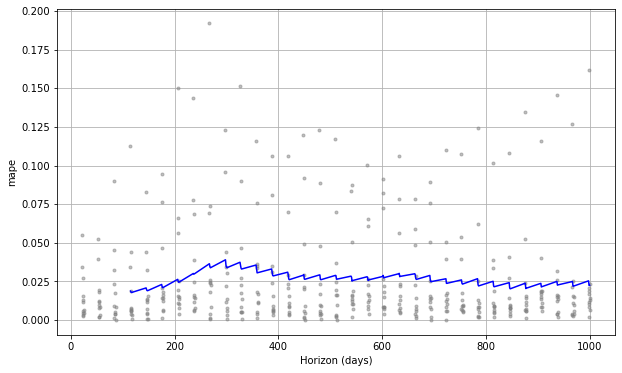

mape: 2.67%


In [15]:
df_cv = cross_validation(prophet, initial='365 days', period='365 days', horizon = '1000 days')
df_p = performance_metrics(df_cv)
fig = plot_cross_validation_metric(df_cv, metric='mape')
plt.show()
print('mape:', '{:.2f}%'.format(100 * df_p['mape'].mean()))

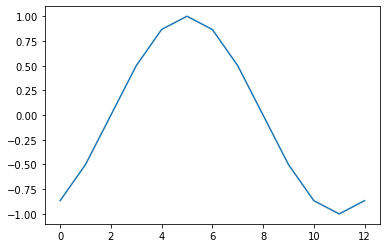

In [16]:
plt.plot(np.sin([(i - 2) * (360 / 12) * (np.pi / 180) for i in range(13)]))

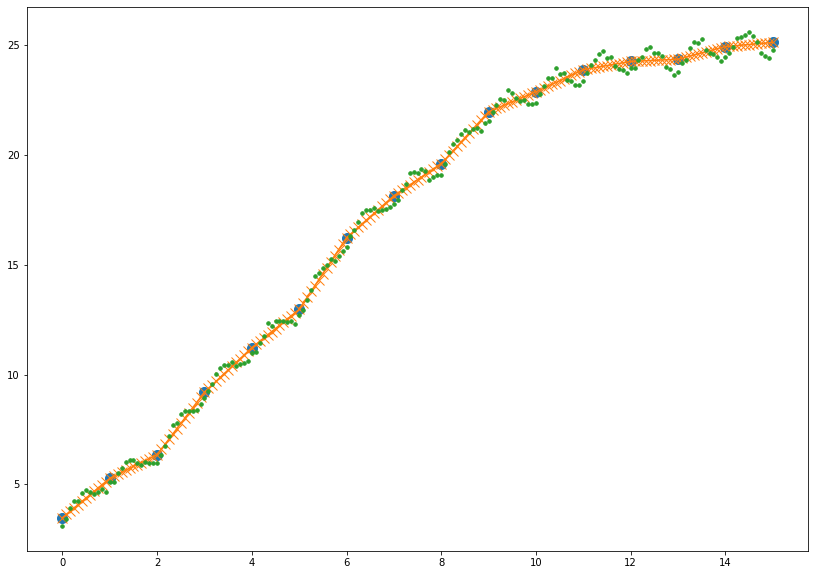

In [17]:
plt.figure(figsize=(14, 10))
plt.plot(x, y, 'o', ms=10)
plt.plot(xvals, yinterp, '-x', ms=10)
plt.plot(xvals, [yinterp[i]  # base value
                 + yinterp[i // 12]  # scale by preceding true recording
                 * np.sin((i - 2) * (360 / 12) * (np.pi / 180))  # apply sinusoidal form to interpolation
                 / 10  # scale sine down a tenth
                 + sum(y) / len(y)  # scale by mean value
                 * (random.uniform(-.01, .01)) # add random noise
                 for i in range(len(yinterp))], '.', ms=7)
plt.show()

In [18]:
df = pd.DataFrame({'ds': pd.to_datetime(pd.date_range('1997-01','2012-02', freq='M').strftime("%Y-%b").tolist()),
                   'y': [yinterp[i]  # base value
                 + yinterp[i // 12]  # scale by preceding true recording
                 * np.sin((i - 2) * (360 / 12) * (np.pi / 180))  # apply sinusoidal form to interpolation
                 / 10  # scale sine down a tenth
                 + sum(y) / len(y)  # scale by mean value
                 * (random.uniform(-.01, .01)) # add random noise
                 for i in range(len(yinterp))]})
df['y'] = (df['y'] * 1000).astype(int)

In [19]:
cap = 26000
floor = 0
df['cap'] = cap
df['floor'] = floor

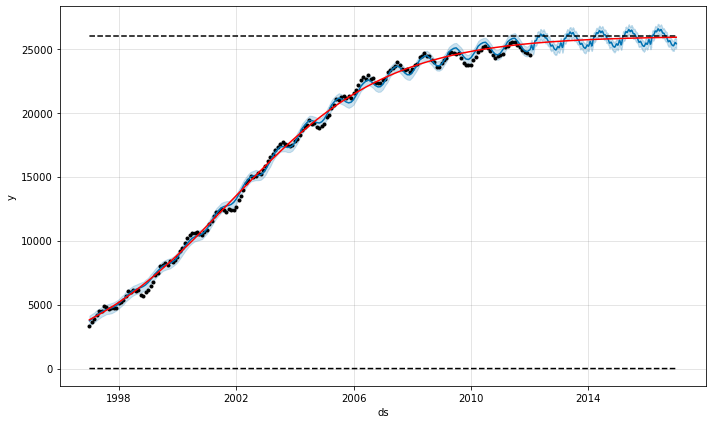

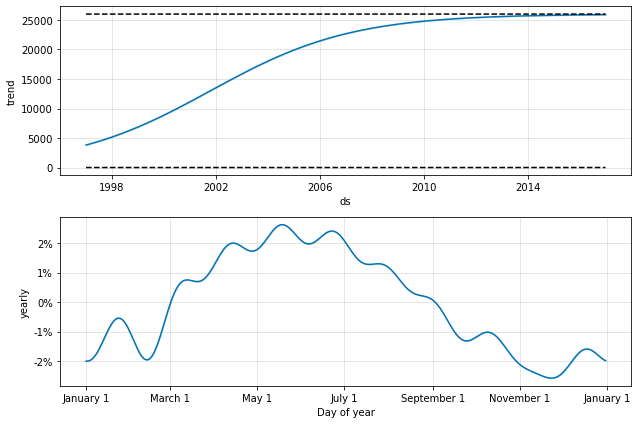

In [20]:
prophet = Prophet(growth='logistic',
                  n_changepoints=25,
                  changepoint_range=0.8,
                  yearly_seasonality=True,
                  weekly_seasonality=False,
                  daily_seasonality=False,
                  holidays=None,
                  seasonality_mode='multiplicative',
                  seasonality_prior_scale=.01,
                  changepoint_prior_scale=.01,
                  mcmc_samples=0)
prophet.fit(df)
future = prophet.make_future_dataframe(periods=365 * 5, freq='D')
future['cap'] = cap
future['floor'] = floor
forecast = prophet.predict(future)
fig = prophet.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet, forecast)
plt.show()
fig2 = prophet.plot_components(forecast)
plt.show()

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


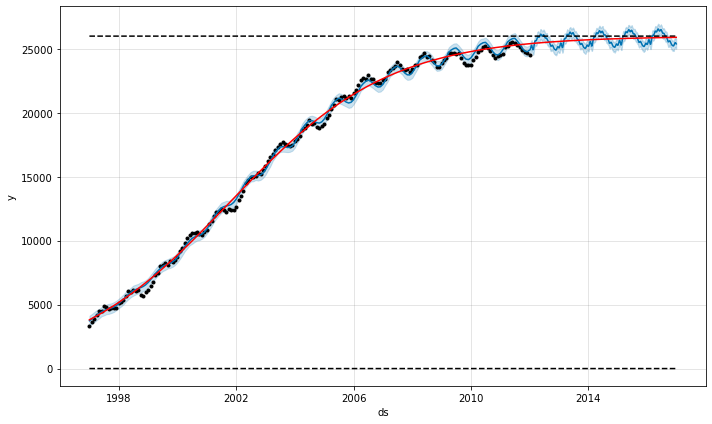

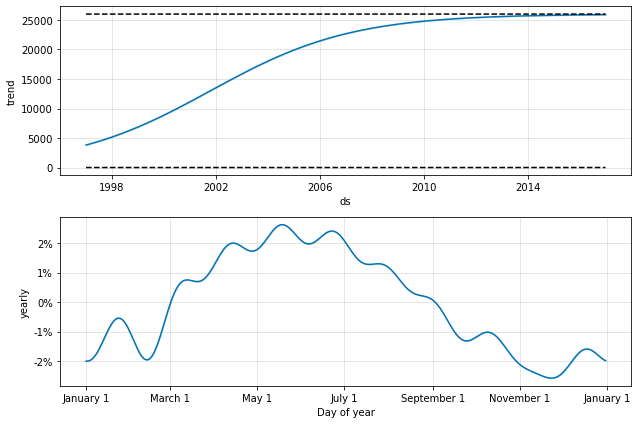

In [21]:
prophet = Prophet(growth='logistic',
                  seasonality_mode='multiplicative',
                  seasonality_prior_scale=.01,
                  changepoint_prior_scale=.01)
prophet.fit(df)
future = prophet.make_future_dataframe(periods=365 * 5, freq='D')
future['cap'] = cap
future['floor'] = floor
forecast = prophet.predict(future)
fig = prophet.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet, forecast)
plt.show()
fig2 = prophet.plot_components(forecast)
plt.show()

In [22]:
df.head()

,ds,y,cap,floor
0,1997-01-01,3345,26000,0
1,1997-02-01,3630,26000,0
2,1997-03-01,3845,26000,0
3,1997-04-01,4177,26000,0
4,1997-05-01,4467,26000,0


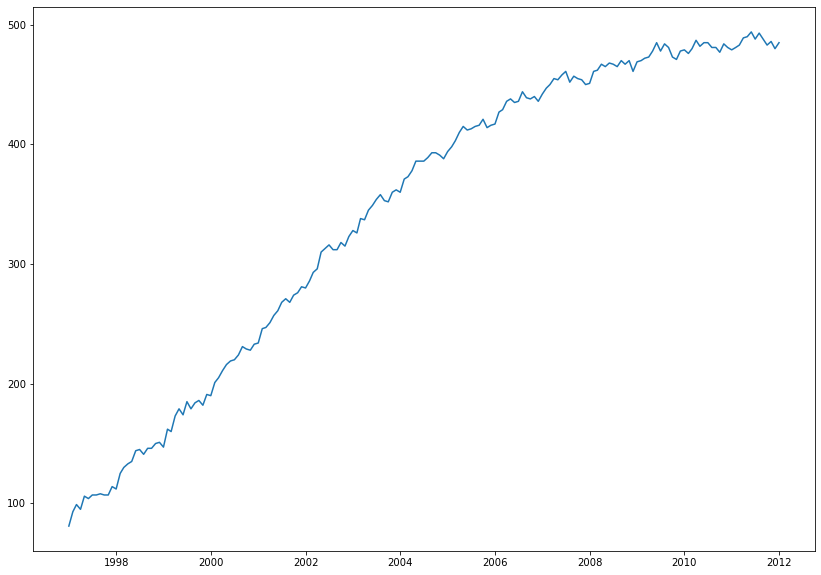

In [23]:
x = pd.to_datetime(pd.date_range('1997-01','2012-02', freq='M').strftime("%Y-%b").tolist())
y = [1 / (1 + np.e ** (-.03 * (val - 50))) for val in range(len(x))]  # create logistic curve
y = [y[idx] + .01 * np.sin((idx - 2) * (360 / 12) * (np.pi / 180)) for idx in range(len(y))]  # add sinusoidal variation
y = [val + random.uniform(-.01, .01) for val in y]  # add noise
y = [int(500 * val) for val in y]  # scale up
plt.figure(figsize=(14, 10))
# plt.scatter(x, y)
plt.plot(x, y)
plt.show()

In [24]:
df = pd.DataFrame({'ds': pd.to_datetime(x), 'y': y})
# df.to_csv('data/wolves.csv', index=False)

In [25]:
cap = 500
floor = 0

df['cap'] = cap
# df['floor'] = floor

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


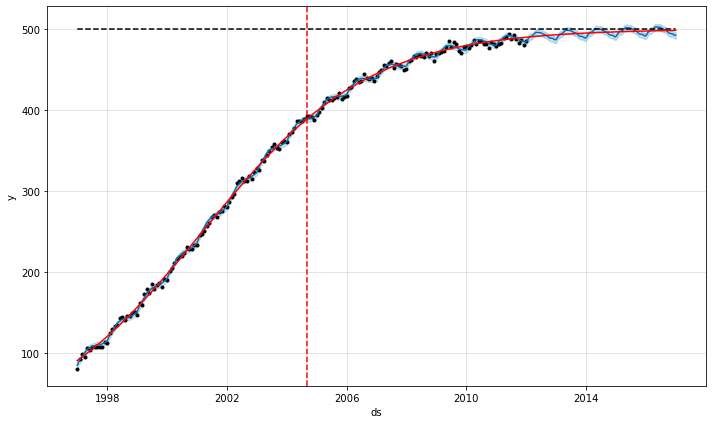

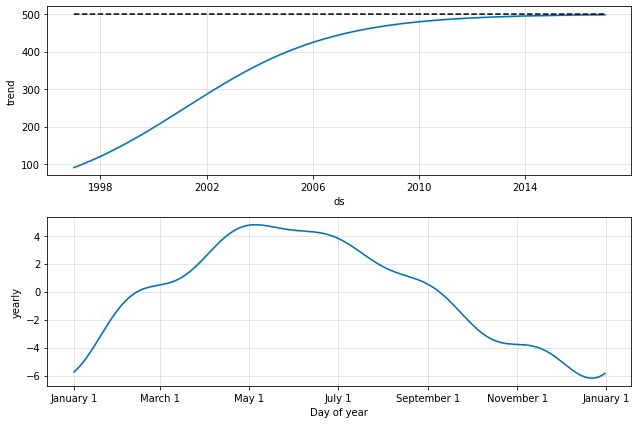

In [26]:
prophet = Prophet(growth='logistic',
                  yearly_seasonality=5)
prophet.fit(df)
future = prophet.make_future_dataframe(periods=365 * 5, freq='D')
future['cap'] = cap
future['floor'] = floor
forecast = prophet.predict(future)
fig = prophet.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet, forecast)
plt.show()
fig2 = prophet.plot_components(forecast)
plt.show()

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


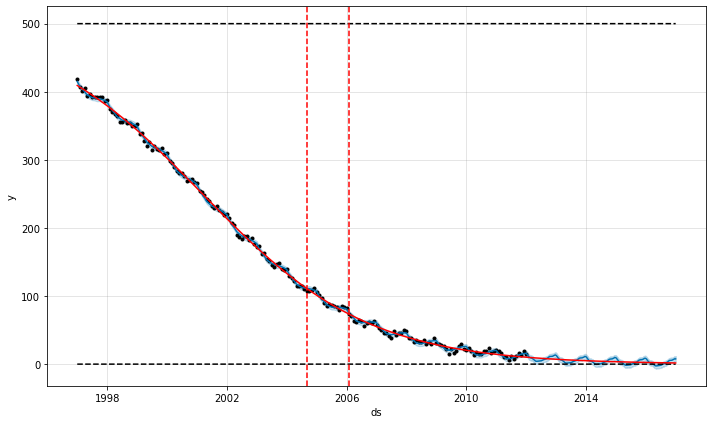

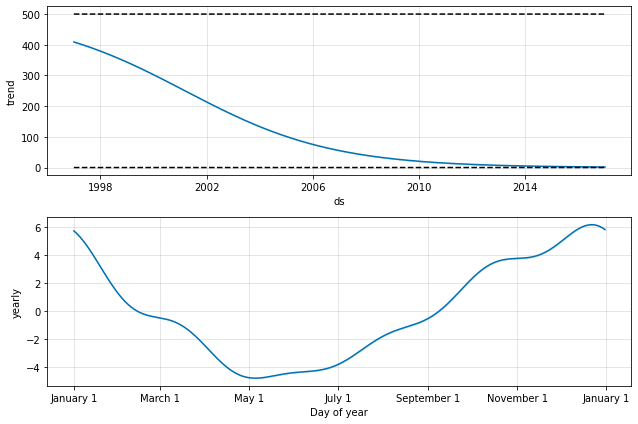

In [27]:
df2 = df.copy()
df2['y'] = cap - df2['y']
df2['floor'] = 0

prophet = Prophet(growth='logistic',
                  yearly_seasonality=5)
prophet.fit(df2)
future = prophet.make_future_dataframe(periods=365 * 5, freq='D')
future['cap'] = cap
future['floor'] = floor
forecast = prophet.predict(future)
fig = prophet.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet, forecast)
plt.show()
fig2 = prophet.plot_components(forecast)
plt.show()